In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torchvision
import torch.nn as nn
import torch.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision
import torchvision.transforms as transforms

In [2]:
# create loaders for mnist
from torchvision.datasets import MNIST
from torchvision import transforms

#upscale to 64 by 64 during transform
train_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = True, transform=transforms.Compose([
    # transforms.Resize(64),
    transforms.ToTensor()
]))
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
test_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = False, transform=transforms.Compose([
    # transforms.Resize(64),
    transforms.ToTensor()
]))
test_batch_size = 64
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size)


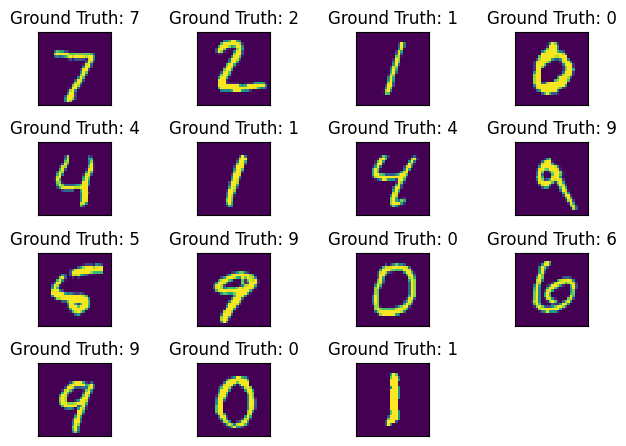

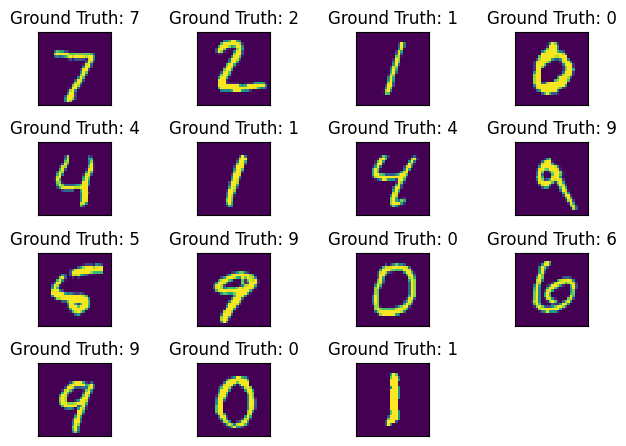

In [3]:
data = enumerate(test_data_loader)
_, (example_data, target) = data.__next__()
fig = plt.figure()
for i in range(15):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='viridis', interpolation='none')
    plt.title(f"Ground Truth: {target[i]}")
    plt.xticks([])
    plt.yticks([])
fig

In [8]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, code_size:int):
        self.code_size = code_size
        super(VariationalAutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
        )
        self.mu_linear = nn.Linear(12, code_size)
        self.sigma_linear = nn.Linear(12, code_size)
        
        self.decoder =  nn.Sequential(
            nn.Linear(code_size, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        self.N = torch.distributions.Normal(0, torch.tensor(1.0))
        if device == "cuda":
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()   

    def forward(self, x):
        x = self.encoder(x)
        latent_space_mean = self.mu_linear(x)
        latent_space_sigma = torch.exp(self.sigma_linear(x))
        z = latent_space_mean + latent_space_sigma * self.N.sample(latent_space_mean.shape)
        # TODO: https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
        self.kl = (latent_space_sigma ** 2 + latent_space_mean ** 2 - torch.log(latent_space_sigma) - 0.5).sum()
        op = self.decoder(z)
        return torch.reshape(op, (-1, 1, 28, 28))

    def get_latent_space(self, x):
        x = self.encoder(x)
        latent_space_mean = self.mu_linear(x)
        latent_space_sigma = torch.exp(self.sigma_linear(x))
        z = latent_space_mean + latent_space_sigma * self.N.sample(latent_space_mean.shape)
        return z

In [16]:
# writer = SummaryWriter()
def train_vae(model: nn.Module, data: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epochs = 10, device = 'cpu'):
    model.to(device)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        i = 0
        error = 0
        for inp, label in data:
            inp = inp.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = ((inp - output) ** 2).sum() + model.kl
            loss.backward()
            optimizer.step()
            error += torch.linalg.norm(loss).item()
            i += 1
        # writer.add_scalar("Loss/train", error / i, epoch + 1)
        print(f"Error for epoch {epoch + 1}: {error / i}")
    
        if epoch % 10 == 0:
            plot_tsne(model, test_data_loader, title='val set')

    return model

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dims = 6
model = VariationalAutoEncoder(latent_dims)
# betas for adam
beta_1 = 0.5
beta_2 = 0.999


cuda


Error for epoch 1: 4843.676123775653


100%|██████████| 157/157 [00:04<00:00, 33.95it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


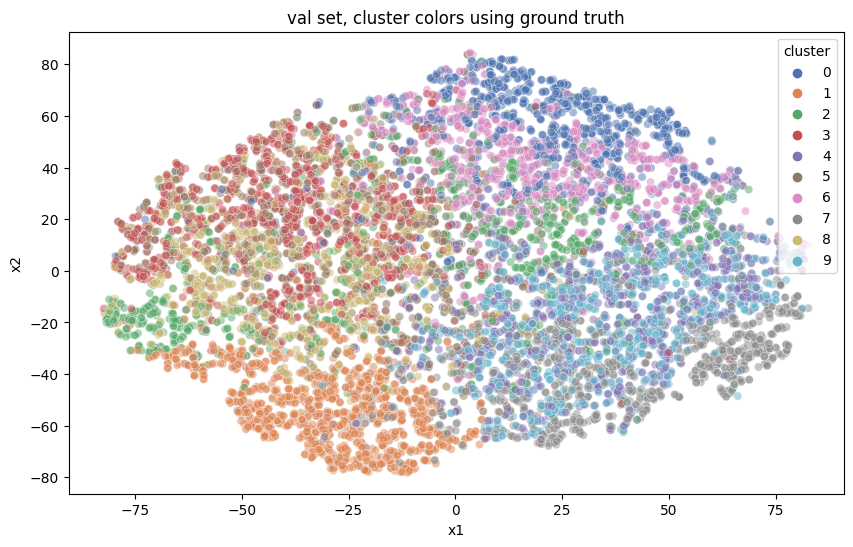

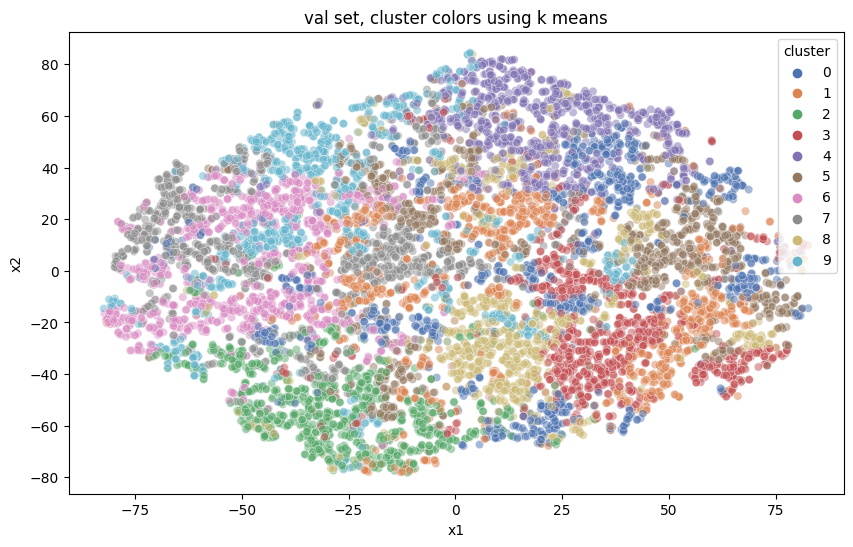

val set 0.8501078707870787
val set 0.16876411678737227
Error for epoch 2: 4844.20439723814
Error for epoch 3: 4834.814529646688
Error for epoch 4: 4828.973002940099
Error for epoch 5: 4823.606986690432
Error for epoch 6: 4822.330735066298
Error for epoch 7: 4810.3243738756
Error for epoch 8: 4813.562416711087
Error for epoch 9: 4808.568886697928
Error for epoch 10: 4806.910049536081
Error for epoch 11: 4806.402267748867


100%|██████████| 157/157 [00:04<00:00, 31.58it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


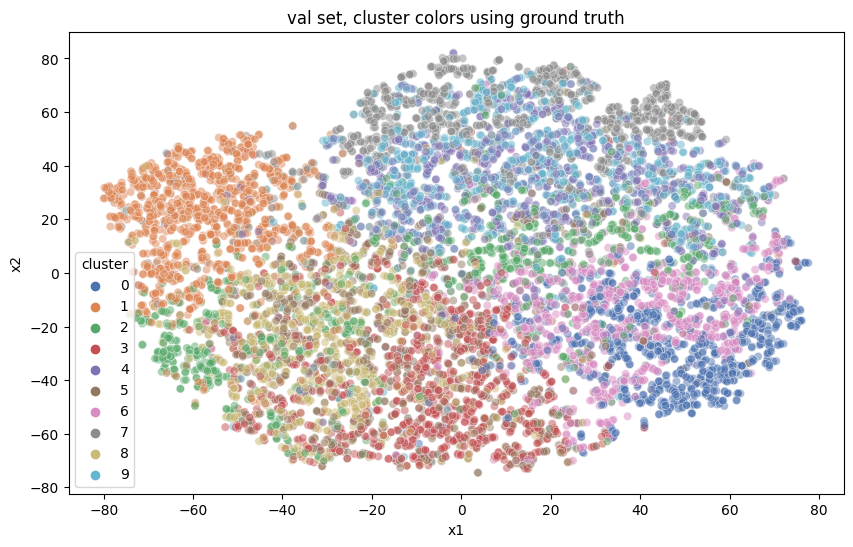

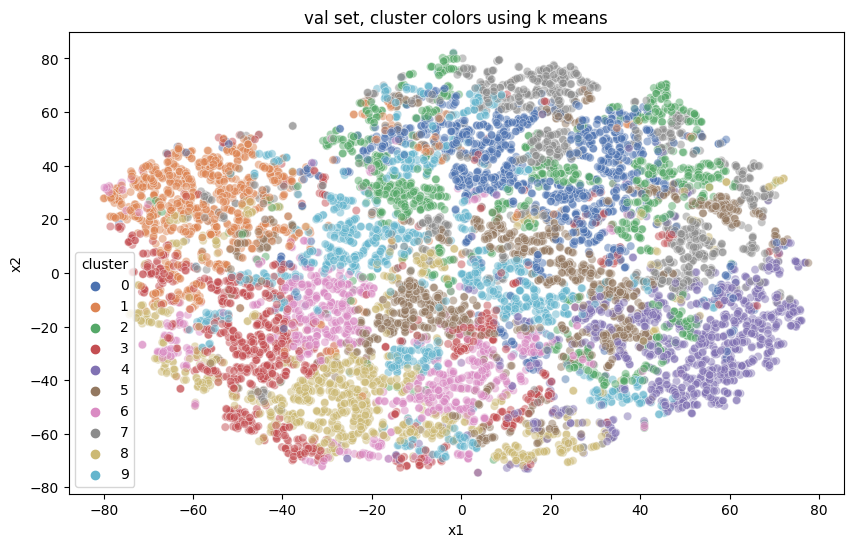

val set 0.8502643064306431
val set 0.1706141943990279
Error for epoch 12: 4804.894481797208
Error for epoch 13: 4799.8680547458025
Error for epoch 14: 4797.052632866637
Error for epoch 15: 4799.180219507929
Error for epoch 16: 4781.660062549973
Error for epoch 17: 4784.3681859258395
Error for epoch 18: 4772.779231805537
Error for epoch 19: 4776.675086828692
Error for epoch 20: 4776.750173865605
Error for epoch 21: 4770.270838365372


100%|██████████| 157/157 [00:04<00:00, 36.68it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


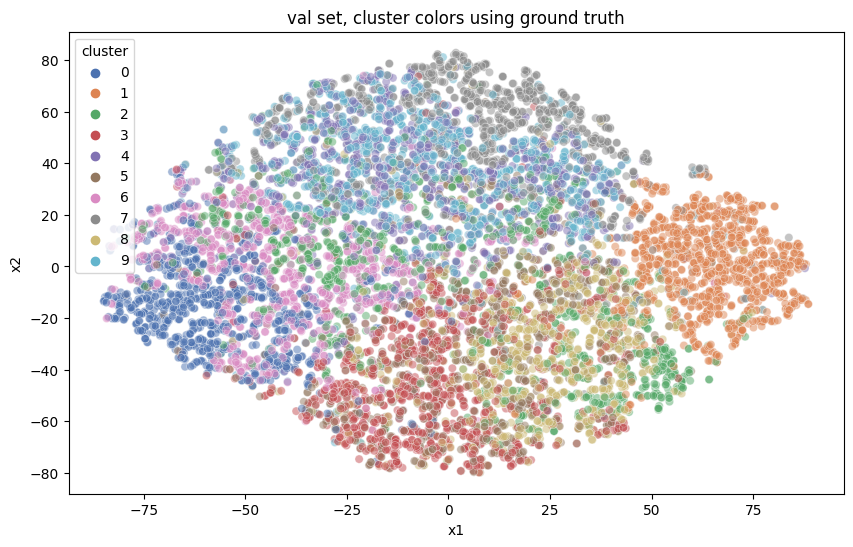

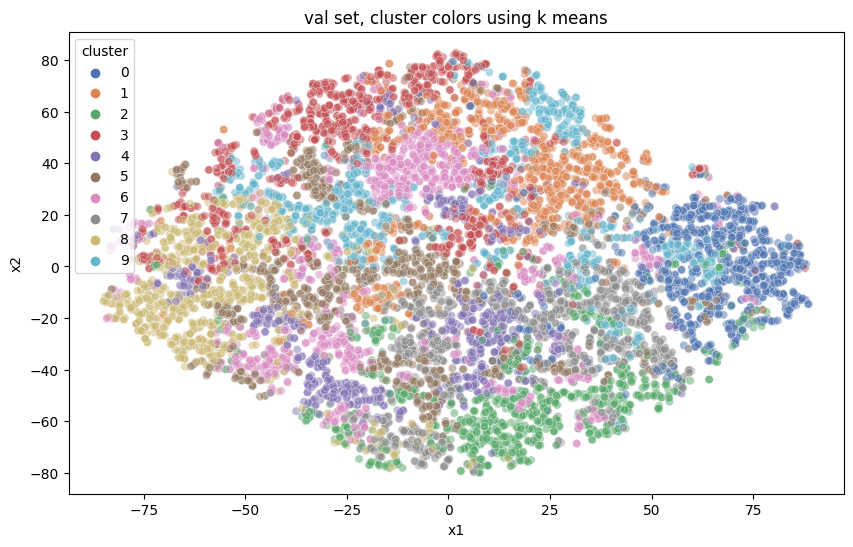

val set 0.8494868486848685
val set 0.16733251619817952
Error for epoch 22: 4765.148238647721
Error for epoch 23: 4765.6058461528855
Error for epoch 24: 4757.596343929071
Error for epoch 25: 4759.654423370036
Error for epoch 26: 4758.17035445679
Error for epoch 27: 4757.2054602128865
Error for epoch 28: 4754.811384449127
Error for epoch 29: 4758.887435034648
Error for epoch 30: 4753.493348859774
Error for epoch 31: 4756.768478165812


100%|██████████| 157/157 [00:04<00:00, 32.55it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


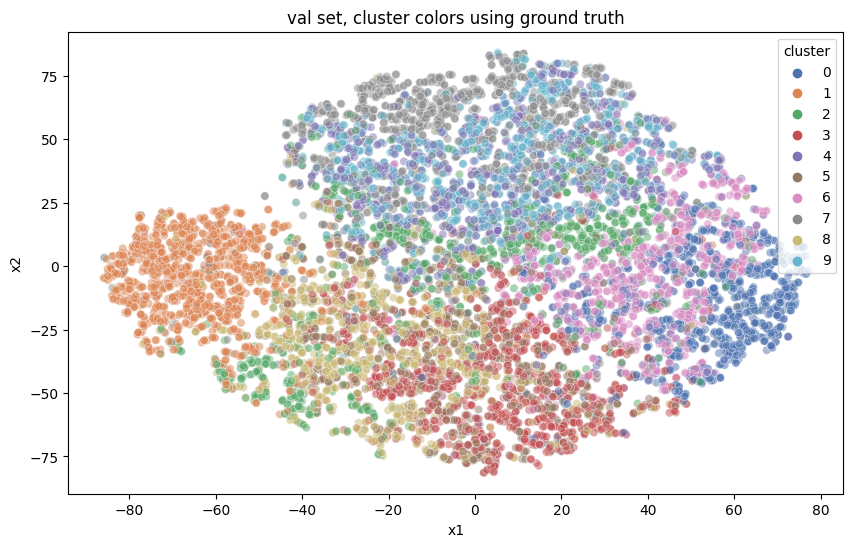

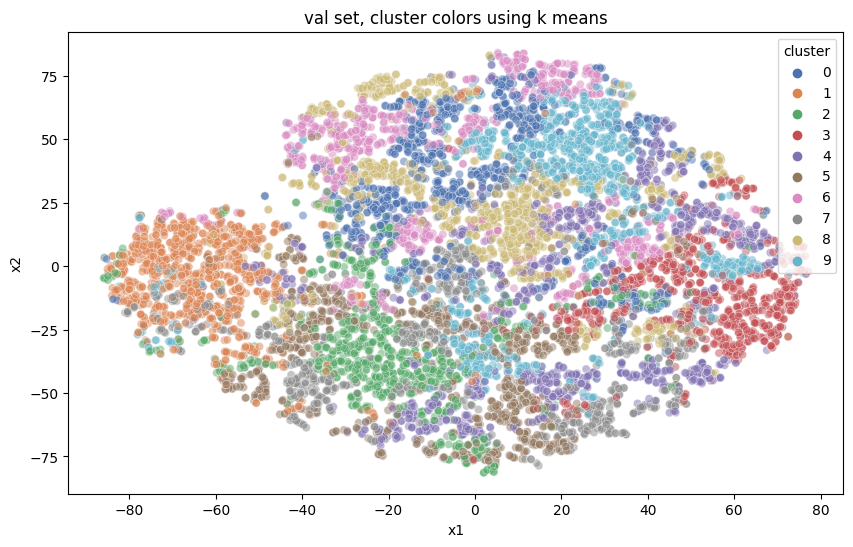

val set 0.8512580458045804
val set 0.17724138813033694
Error for epoch 32: 4742.54330919343
Error for epoch 33: 4747.134468908249
Error for epoch 34: 4743.812730606177
Error for epoch 35: 4737.154165174407
Error for epoch 36: 4747.718015495902
Error for epoch 37: 4750.83747626266
Error for epoch 38: 4742.324509220082
Error for epoch 39: 4731.083438832623
Error for epoch 40: 4736.1188595249205
Error for epoch 41: 4721.942351058602


100%|██████████| 157/157 [00:04<00:00, 35.76it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


In [17]:
optimizer = torch.optim.Adam(model.parameters())
model = train_vae(model, train_data_loader, optimizer, device=device, epochs=100)

In [12]:
# set jupyter auto reload and 2
%load_ext autoreload
%autoreload 2
from omegaconf import OmegaConf
import torch
from torch.optim import lr_scheduler
import torch.nn as nn

from tqdm import tqdm
from utils.train_utils import select_device, fix_seed, log_images, calculate_metrics_fromloader, pred_fn, image_float2int
from utils.builder import build_data, build_models, build_optimizer
import torch.nn.functional as F
import wandb
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os

/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def plot_tsne(model, data_loader, title='val set'): 
    model.eval()
    X = []
    X_labels = []
    for batch in tqdm(data_loader):
        features = batch[0]
        features = model.get_latent_space(features.to(device))
        # features = features.view(features.size(0), -1)
        labels = batch[1]
        X.append(features.detach().cpu().numpy())
        X_labels.append(labels.detach().cpu().numpy())

    # get X and X labels
    X = np.concatenate(X, axis=0)
    X_labels = np.concatenate(X_labels, axis=0)
    print(X.shape, X_labels.shape)
    
    k = 10

    # Create a KMeans object
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # Get the labels for each data point
    kmeans_labels = kmeans.labels_

    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(X)
    dftsne = pd.DataFrame(tsne_embeddings)
    dftsne['cluster'] = pd.Series(X_labels)
    dftsne.columns = ['x1','x2','cluster']
    
    dftsne_kmeans = dftsne.copy()
    dftsne_kmeans['cluster'] = kmeans_labels
    # os.makedirs(f"output/{config.model_type}", exist_ok=True)
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",palette="deep", alpha=0.5).set_title(title + ", cluster colors using ground truth")
    plt.show()
    # plt.savefig(f"output/{config.model_type}/tsne_gt.png")
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne_kmeans,x='x1', y='x2', hue='cluster', legend='full', palette="deep", alpha=0.5).set_title(title+", cluster colors using k means")
    plt.show()
    # plt.savefig(f"output/{config.model_type}/tsne_kmeans.png")

    print(title, metrics.rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))
    print(title, metrics.adjusted_rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))


100%|██████████| 157/157 [00:04<00:00, 33.19it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 6) (10000,)


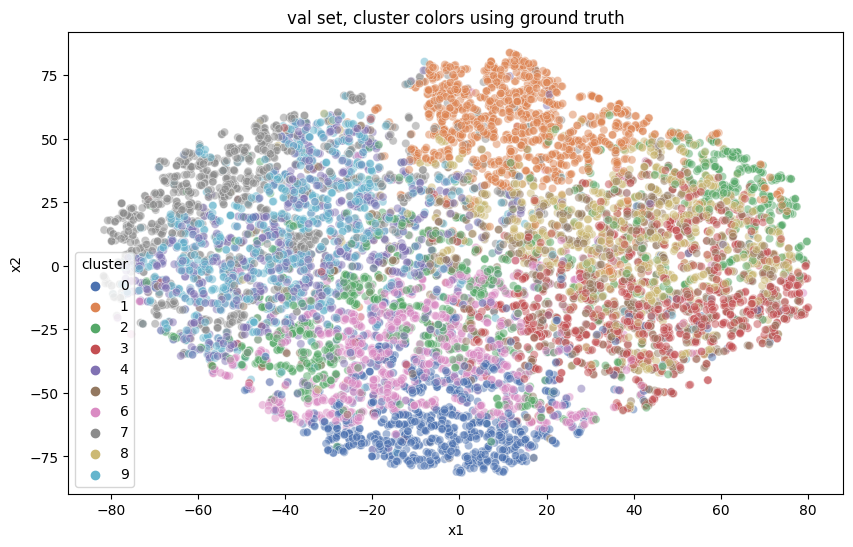

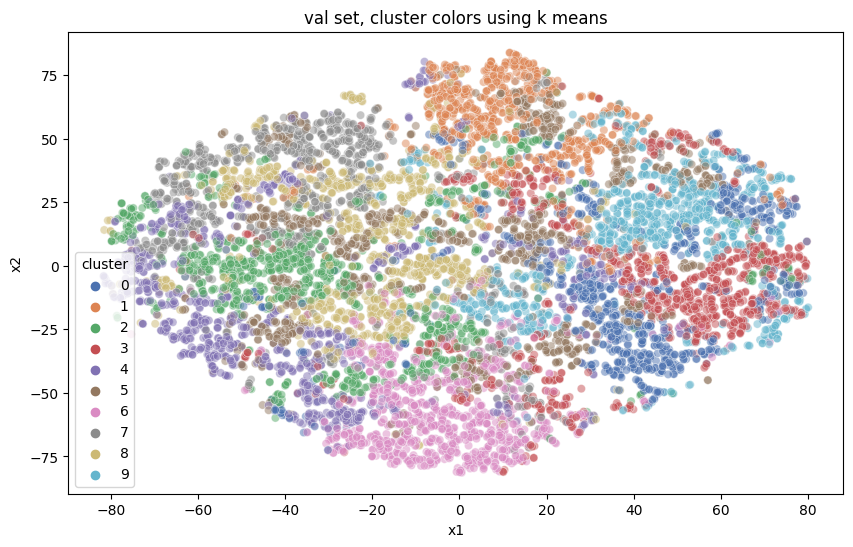

val set 0.8485107310731073
val set 0.1609481125395313


In [14]:
plot_tsne(model, test_data_loader, title='val set')